## Code for peak fitting of apatite sulfur K-edge XANES spectra

In [23]:
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sb
from scipy.optimize import curve_fit
from scipy.special import erfc
import os
mpl.rcParams['font.family'] = 'Arial'

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

# EMG function to fit background
def emg_unit(x, mu, sigma, lam):
    """Normalized EMG with asymptote from 0 to 1"""
    part1 = (lam / 2) * np.exp((lam / 2) * (2 * mu + lam * sigma**2 - 2 * x))
    part2 = erfc((mu + lam * sigma**2 - x) / (np.sqrt(2) * sigma))
    emg_raw = part1 * part2
    emg_min = np.min(emg_raw)
    emg_max = np.max(emg_raw)
    return (emg_raw - emg_min) / (emg_max - emg_min)

def emg_scaled(x, sigma, lam, A, baseline):
    return A * emg_unit(x, mu_fixed, sigma, lam) + baseline

# Import data
data = pd.read_csv('../data/S_XANES_filtered.csv')
energy = pd.to_numeric(data.columns, errors='coerce')[10:]

s6range = [2.4795, 2.4850] # Range to fit peak to for S6+
s4range = [2.4765, 2.4800] # Range to fit peak to for S2-
s2range = [2.469, 2.472] # Range to fit peak to for S2-
s1range = [2.472, 2.475] # Range to fit peak to for S2-

# Find the index for which to filter the S6+ peak
s6_range_min = np.argmin(np.absolute(energy - s6range[0]))
s6_range_max = np.argmin(np.absolute(energy - s6range[1]))
s6_x = energy[s6_range_min:s6_range_max]
s6mean = (s6range[1]-s6range[0])+s6range[0]
s6sigma = 0.01

# Find the index for which to filter the S4+ peak
s4_range_min = np.argmin(np.absolute(energy - s4range[0]))
s4_range_max = np.argmin(np.absolute(energy - s4range[1]))
s4_x = energy[s4_range_min:s4_range_max]
s4mean = (s4range[1]-s4range[0])+s4range[0]
s4sigma = 0.01

# Find the index for which to filter the S2- peak
s2_range_min = np.argmin(np.absolute(energy - s2range[0]))
s2_range_max = np.argmin(np.absolute(energy - s2range[1]))
s2_x = energy[s2_range_min:s2_range_max]
s2mean = (s2range[1]-s2range[0])+s2range[0]
s2sigma = 0.01

# Find the index for which to filter the S2- peak
s1_range_min = np.argmin(np.absolute(energy - s1range[0]))
s1_range_max = np.argmin(np.absolute(energy - s1range[1]))
s1_x = energy[s1_range_min:s1_range_max]
s1mean = (s1range[1]-s1range[0])+s1range[0]
s1sigma = 0.01

<>:120: SyntaxWarning: invalid escape sequence '\S'
<>:120: SyntaxWarning: invalid escape sequence '\S'
/var/folders/pf/__j8h2d157772zgzy8kkpjr80000gp/T/ipykernel_4125/3701033946.py:120: SyntaxWarning: invalid escape sequence '\S'
  plt.annotate('S$^{6+}$/$\Sigma$S = %.2f' % peakratio, xy = (0.15,0.85), xycoords = 'figure fraction')


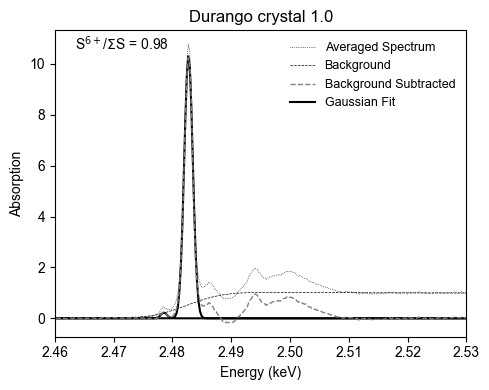

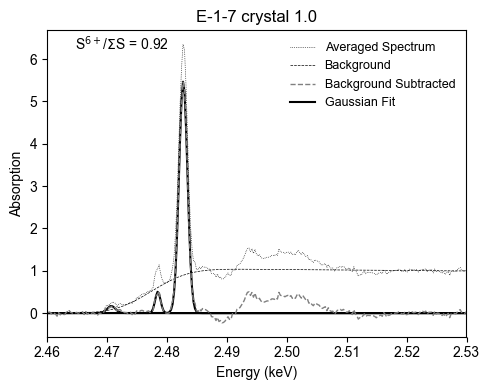

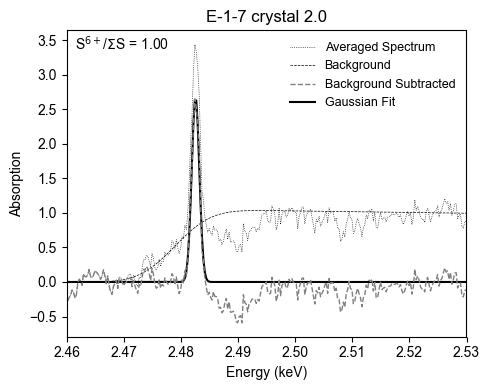

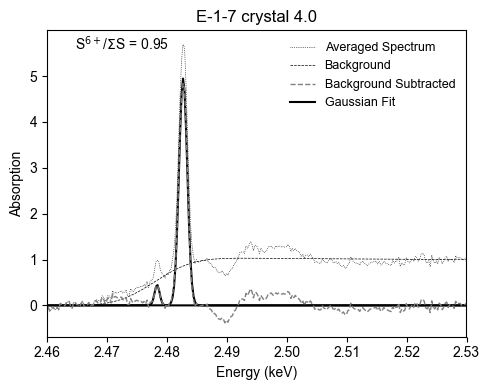

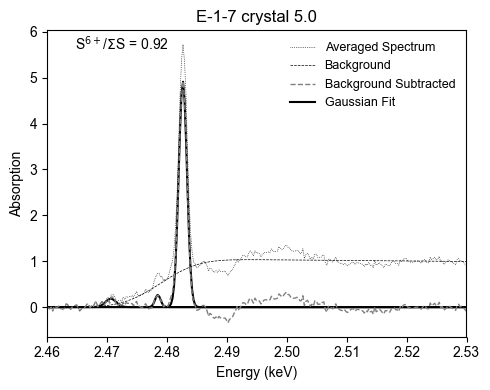

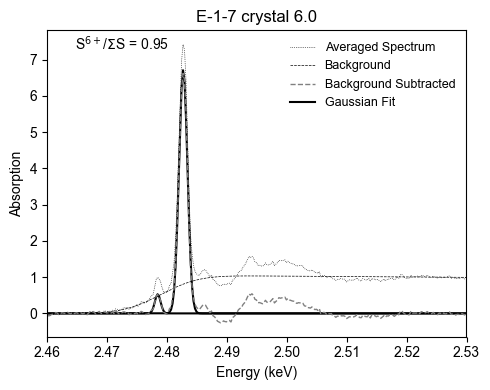

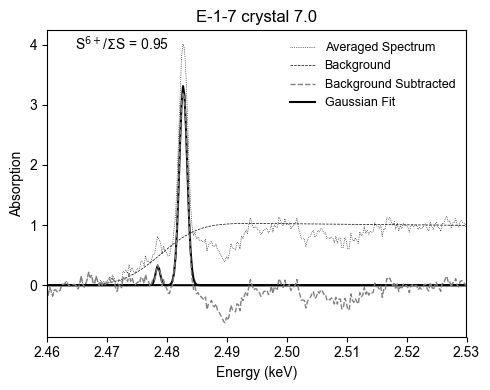

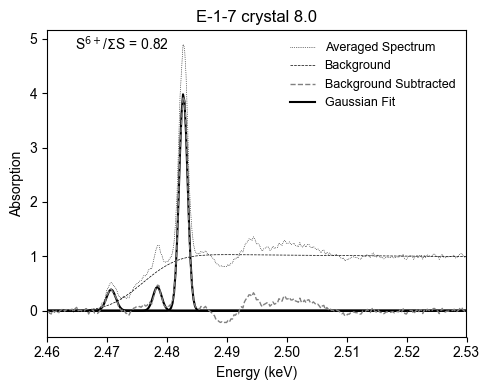

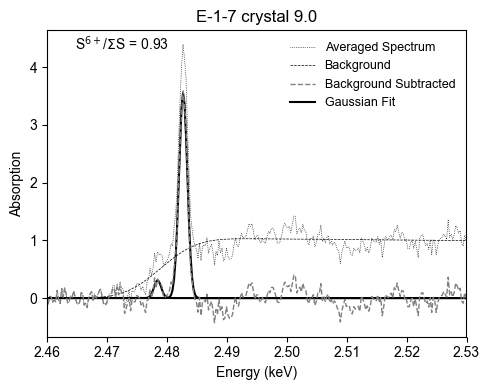

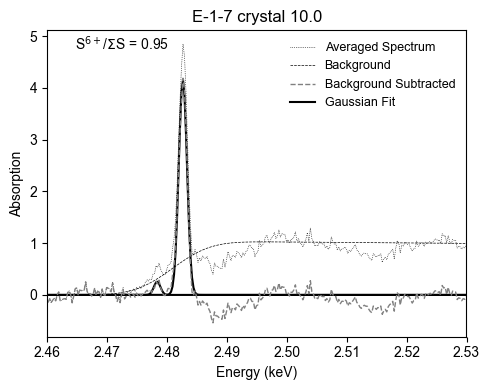

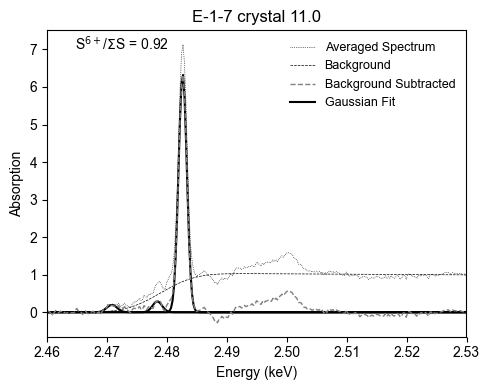

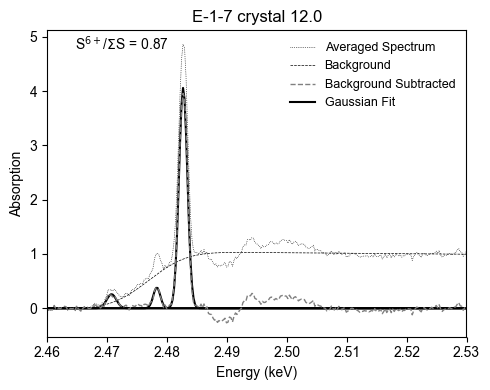

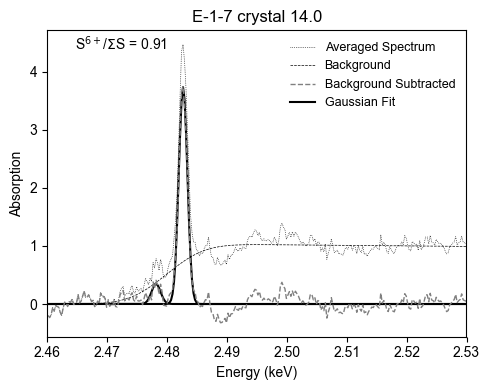

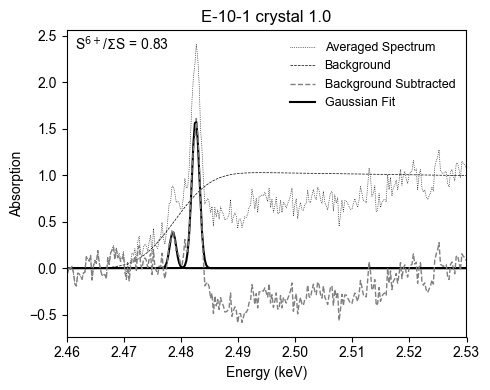

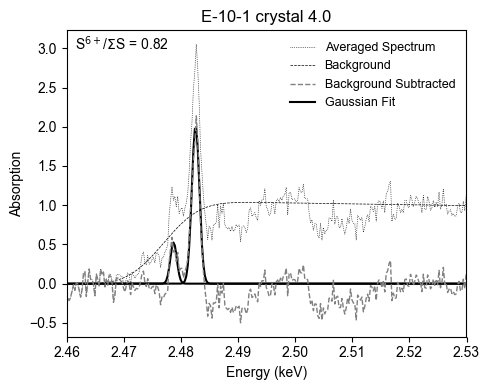

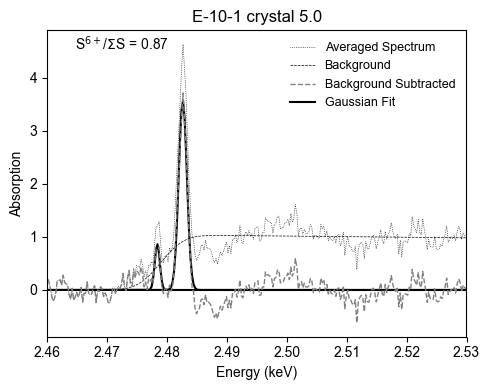

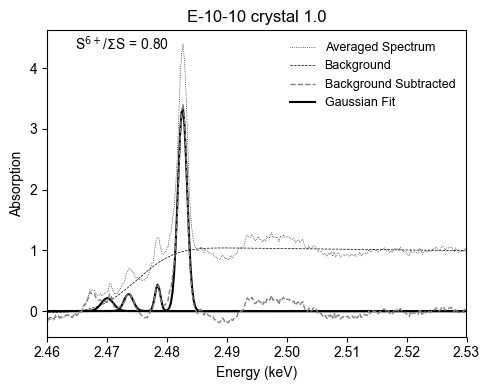

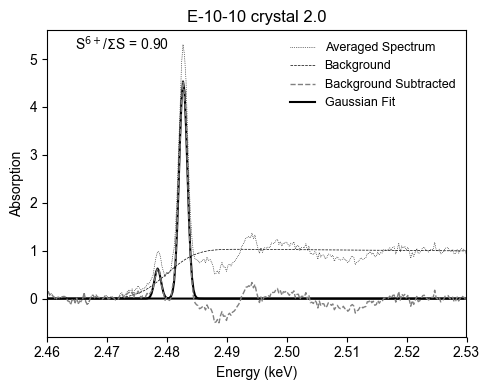

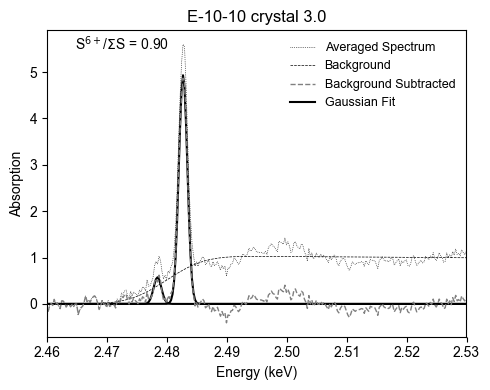

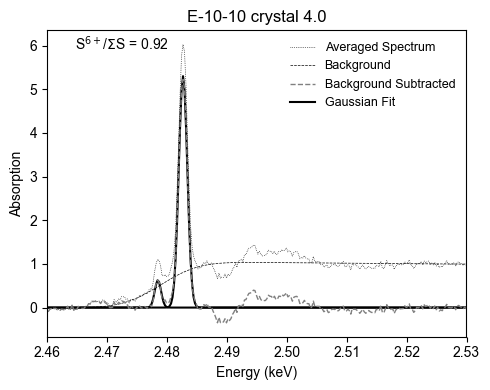

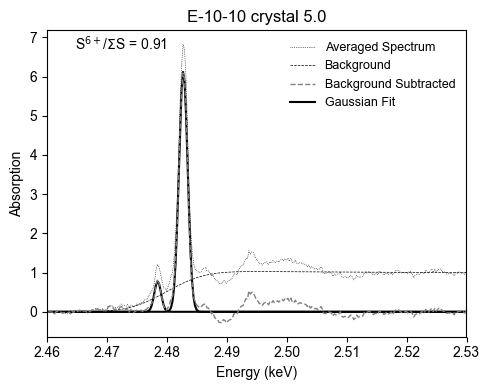

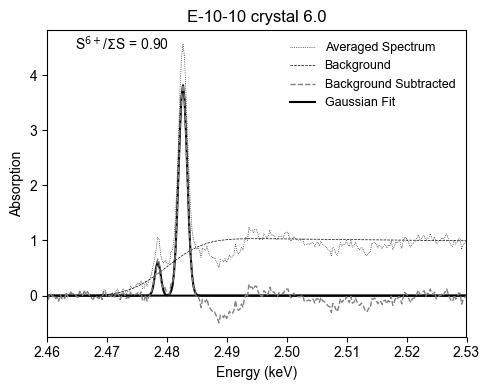

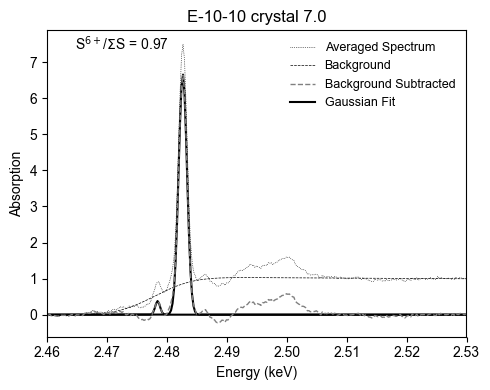

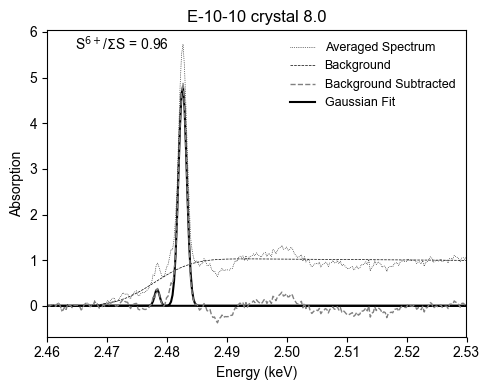

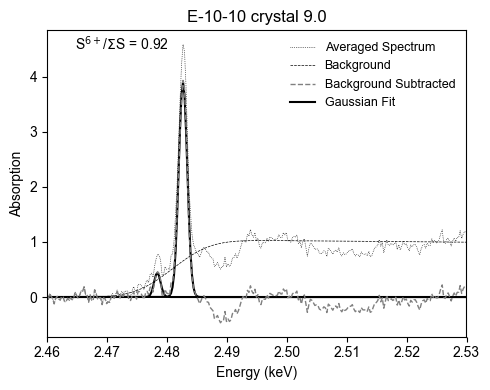

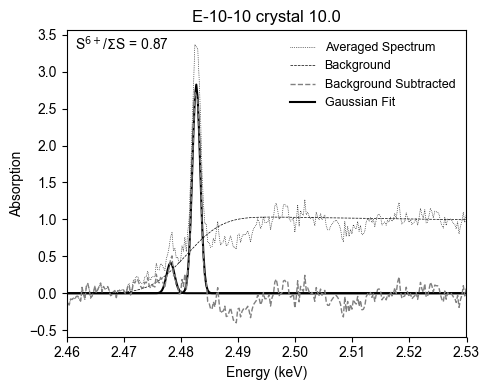

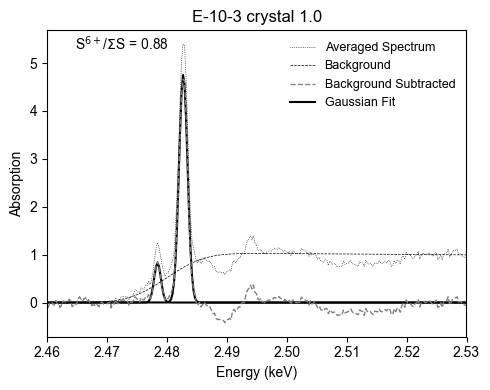

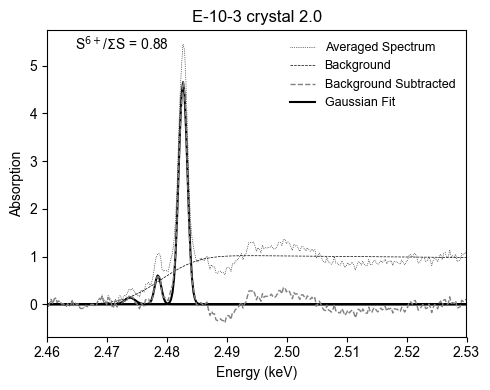

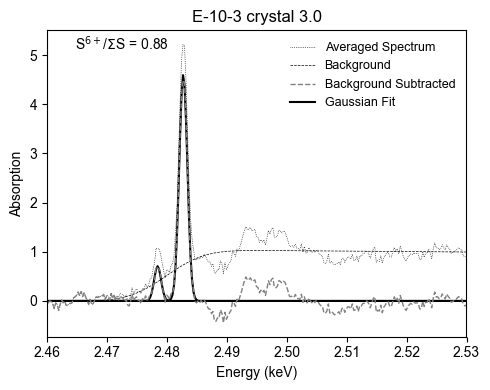

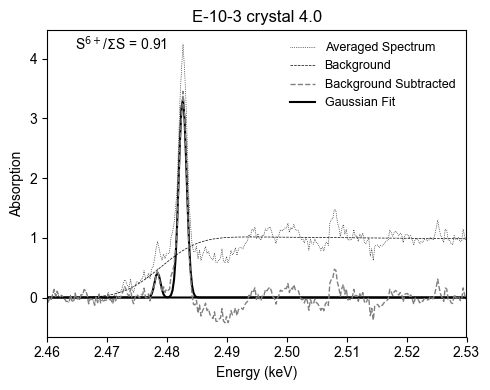

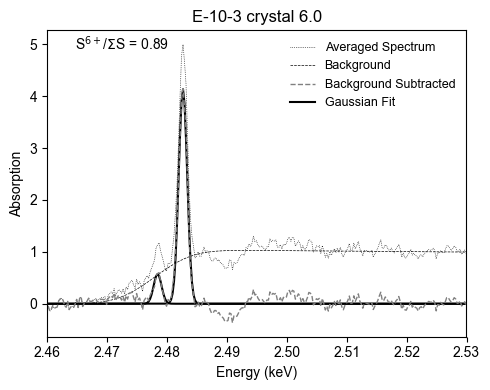

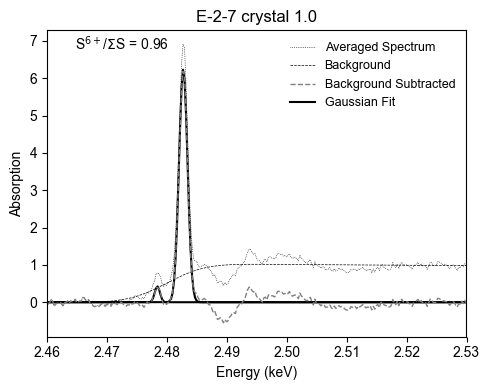

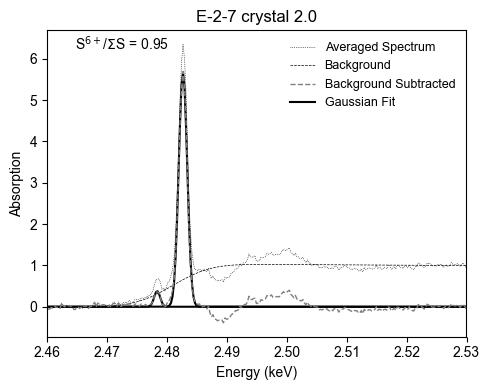

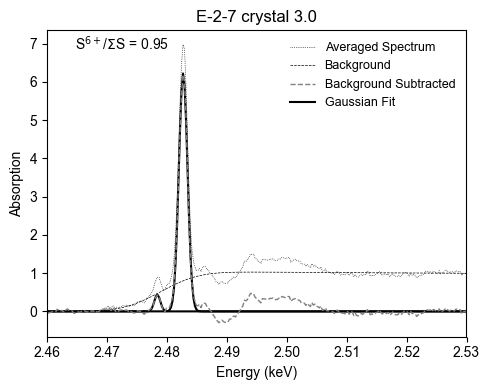

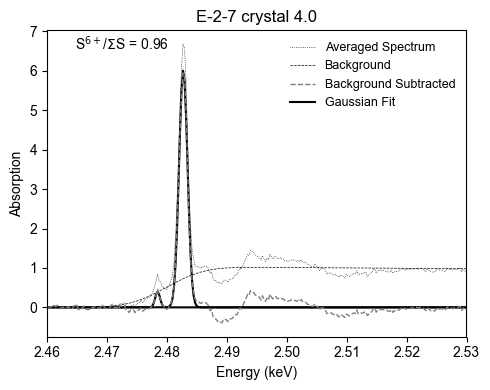

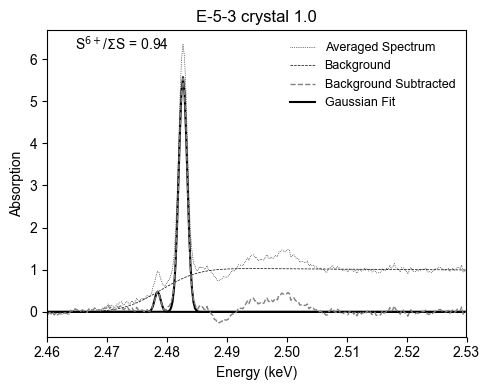

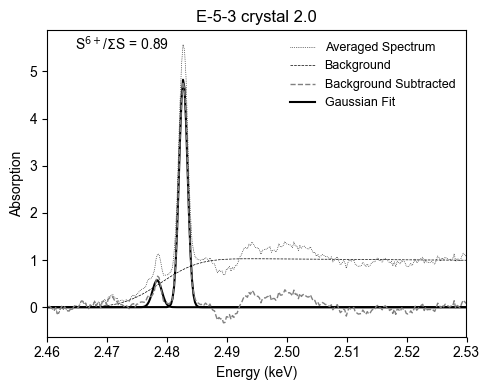

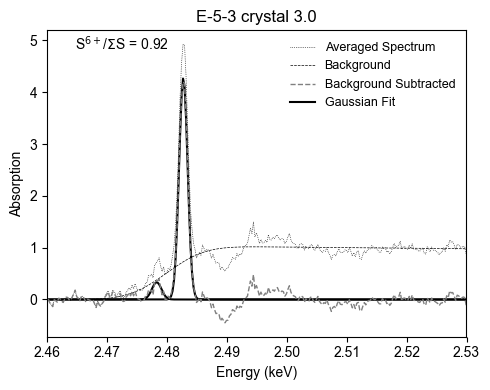

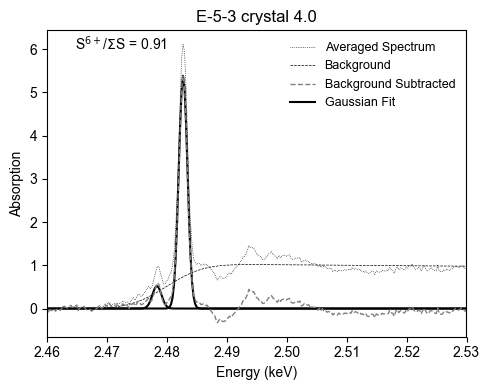

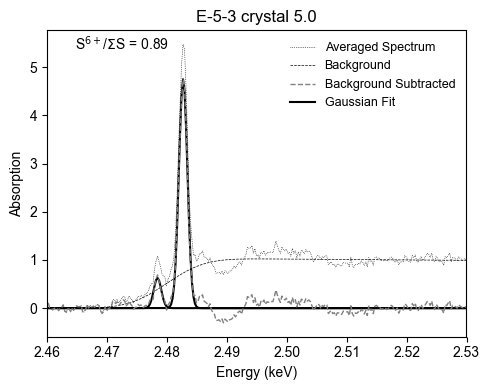

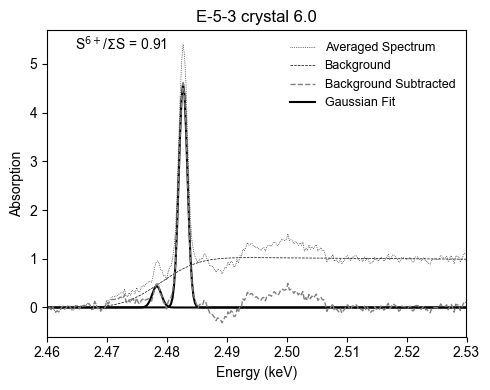

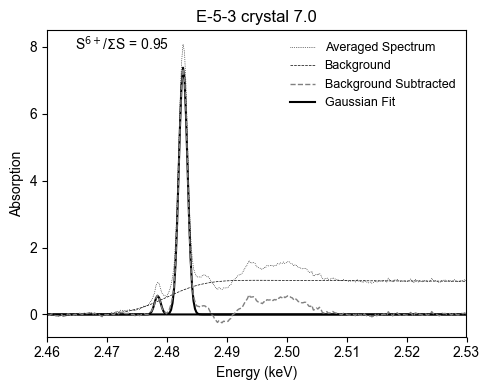

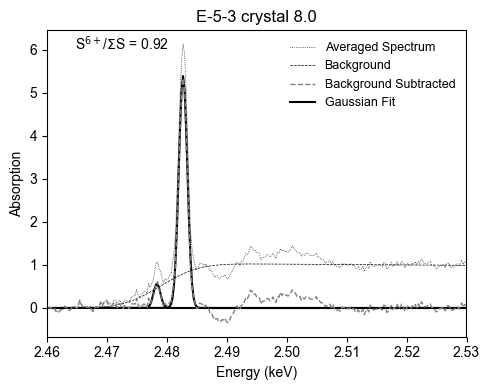

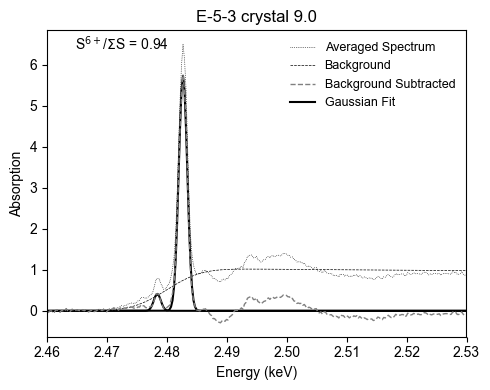

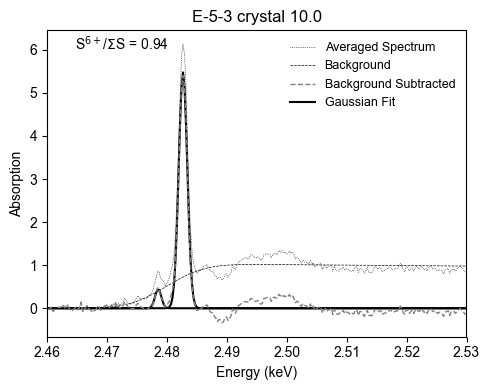

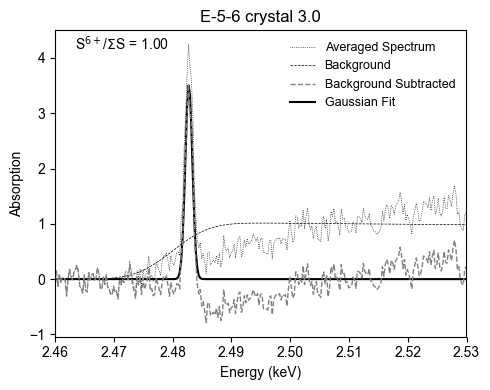

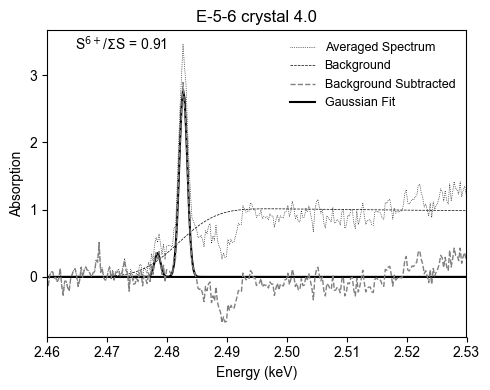

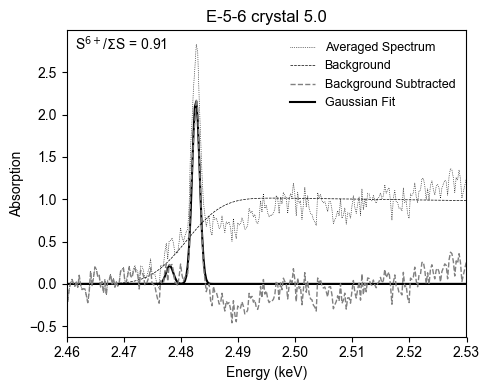

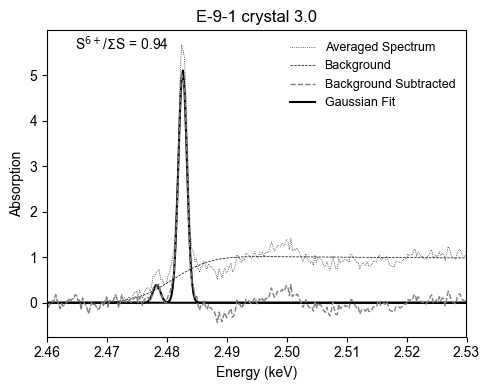

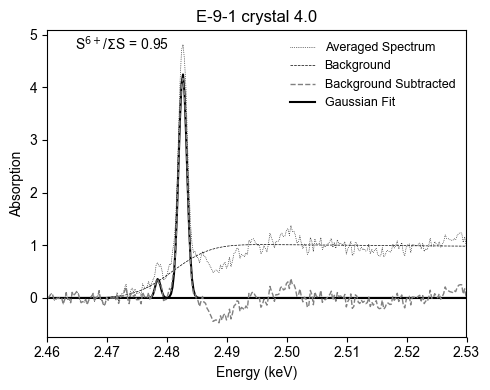

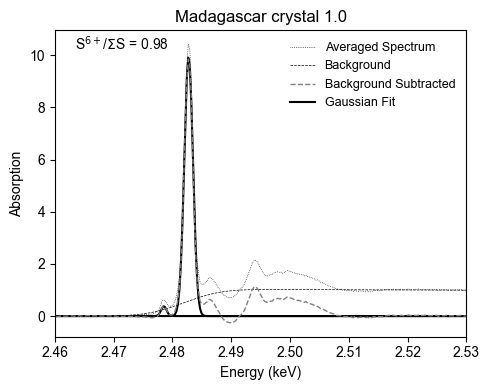

In [38]:
sample_groups = [data.groupby('Sample').get_group(x) for x in data.groupby('Sample').groups] # Group by sample

all_results = []

for sample in sample_groups:
    crystal_groups = [sample.groupby('Crystal').get_group(x) for x in sample.groupby('Crystal').groups] # Group by crystal to average repeat analyses of each crystal
    
    for crystal in crystal_groups:
        info = crystal.iloc[:, 0:-280]
        sample_name = crystal['Sample'].iloc[0]
        crystal_name = crystal['Crystal'].iloc[0]
        crystal = crystal.iloc[:, -280:]
        average = np.mean(crystal, axis = 0) # Calculate average spectrum
        
        # --- Fit background ---
        mu_fixed = info['Mu position'].iloc[0] # inflection point in keV (these are selected for best fit)
        
        # Select pre-edge and post-edge regions
        pre_edge = (energy < 2.468)
        post_edge = (energy > info['Postedge'].iloc[0])
        
        pre_edge_mean = np.mean(average[pre_edge])
        post_edge_mean = np.mean(average[post_edge])
        
        average = (average - pre_edge_mean) / (post_edge_mean - pre_edge_mean)
        
        background_x = np.concatenate((energy[pre_edge], energy[post_edge]))
        background_y = np.concatenate((average[pre_edge], average[post_edge]))
        
        p0 = [0.0003, 1, max(background_y), min(background_y)]  # set initial parameters for the fit of the EMG function
        bounds = ([1e-6, 0.9, 0, -np.inf], [0.005, 1.1, np.inf, np.inf]) # bounds for these parameters
        
        # Fit EMG function
        popt, _ = curve_fit(emg_scaled, background_x, background_y, p0=p0, bounds=bounds, maxfev=10000)
        
        # Evaluate EMG background over full energy range
        emg_fit_full = emg_scaled(energy, *popt)
        
        # force background to 0 at pre-edge, 1 at post-edge
        emg_pre = np.mean(emg_fit_full[pre_edge])
        emg_post = np.mean(emg_fit_full[post_edge])
        emg_fit_norm = (emg_fit_full - emg_pre) / (emg_post - emg_pre)
        
        # Subtract background
        y_corrected = average - emg_fit_norm
        
        # --- Plot ---
        plt.figure(figsize=(5,4))
        plt.plot(energy, average, label='Averaged Spectrum', color = 'black', linestyle = 'dotted', linewidth = 0.5)
        plt.plot(energy, emg_fit_norm, color = 'black', linestyle = '--', label='Background', linewidth = 0.5)
        plt.plot(energy, y_corrected, color = 'gray', linestyle = 'dashed', label='Background Subtracted', linewidth = 1)
        

            
        peak_dict = {}
        total_peak_area = 0
        s_peaks_present = info[['S2-', 'S-', 'S4+', 'S6+']].iloc[0]

        # Now fit Gaussian peaks to sulfur species where present
        if s_peaks_present['S4+'] == 'x':
            try:
                y = y_corrected[s4_range_min:s4_range_max].values # interval for s6 to fit to
                popt,pcov = curve_fit(gaus,s4_x,y,p0=[1,s4mean,s4sigma]) # fit a gaussian curve
                s4curve = gaus(energy,*popt) # save fitted peak
                peak_dict['S4+'] = s4curve
                s4area = np.trapz(energy,gaus(energy,*popt)) # Calculate peak area ratio
                total_peak_area = total_peak_area + s4area
                plt.plot(energy,s4curve, color = 'black', zorder = 0.1)
            except:
                print('S4+ failed')
                pass # doing nothing on exception
        
        if s_peaks_present['S2-'] == 'x':
            try:
                y = y_corrected[s2_range_min:s2_range_max].values # interval for s6 to fit to    
                popt,pcov = curve_fit(gaus,s2_x,y,p0=[1,s2mean,s2sigma]) # fit a gaussian curve
                s2curve = gaus(energy,*popt) # save fitted peak
                peak_dict['S2-'] = s2curve
                s2area = np.trapz(energy,gaus(energy,*popt))
                total_peak_area = total_peak_area + s2area
                plt.plot(energy,s2curve, color = 'black', zorder = 0.1)
            except:
                print('S2- failed')
                pass
            
        if s_peaks_present['S-'] == 'x':
            try:
                y = y_corrected[s1_range_min:s1_range_max].values # interval for s6 to fit to    
                popt,pcov = curve_fit(gaus,s1_x,y,p0=[1,s1mean,s1sigma]) # fit a gaussian curve
                s1curve = gaus(energy,*popt) # save fitted peak
                peak_dict['S-'] = s1curve
                s1area = np.trapz(energy,gaus(energy,*popt))
                total_peak_area = total_peak_area + s1area
                plt.plot(energy,s1curve, color = 'black', zorder = 0.1)
            except:
                print('S- failed')
                pass
            
        if s_peaks_present['S6+'] == 'x':
            try:
                y = y_corrected[s6_range_min:s6_range_max].values # interval for s6 to fit to
                popt,pcov = curve_fit(gaus,s6_x,y,p0=[1,s6mean,s6sigma]) # fit a gaussian curve
                s6curve = gaus(energy,*popt)
                peak_dict['S6+'] = s6curve
                s6area = np.trapz(energy,gaus(energy,*popt))
                total_peak_area = total_peak_area + s6area
                peakratio = s6area/total_peak_area
                plt.plot(energy,s6curve, color = 'black', label = 'Gaussian Fit', zorder = 0.1)
            except:
                print('S6+ failed')
                peakratio = 0
                pass
            
        else:
            peakratio = 0

        export = pd.concat([info.iloc[0,:], average, pd.Series(peakratio, name = 'S6/Stotal')], axis = 0)
        all_results.append(export)
        
        plt.annotate('S$^{6+}$/$\Sigma$S = %.2f' % peakratio, xy = (0.15,0.85), xycoords = 'figure fraction')
        plt.title(sample_name + ' crystal ' + str(crystal_name))
        plt.legend(edgecolor = 'black', fontsize = 9, frameon=False)
        plt.xlabel('Energy (keV)')
        plt.ylabel('Absorption')
        plt.xlim([2.46, 2.53])
        plt.rcParams['svg.fonttype'] = 'none'
        plt.tight_layout()        
        plt.show()
    

all_results = pd.DataFrame(all_results)